In [1]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve

plt.style.use('../maroon_ipynb.mplstyle')

From lecture 16 notes, we are finding the resonant frequency and bandwidth of 

$$T(s)=\frac{40}{5s^2+17s+300}$$

# Resonant Frequency

In [2]:
# Getting magnitude and phase using numpy
T_jw = lambda w: 40/(5*(1j*w)**2 + 17*1j*w + 300)  # Returns complex number at given omega

omegas = np.linspace(1, 100, 10_000)
mag = np.abs(T_jw(omegas))
phase = np.angle(T_jw(omegas))

# Finding the resonant frequency
wn = np.sqrt(300/5)
zeta = 17/(2*np.sqrt(5*300))
wr = wn*np.sqrt(1 - 2*zeta**2)
wr  # rad/s

7.363423117002037

In [3]:
# Checking by finding the omega where mag is maximum
omegas[max(mag) == mag][0]

7.366336633663367

Additionally, you can find the natural frequency and damping ratio using `ct.damp()`.

In [4]:
T = ct.tf(40, [5, 17, 300])
T

TransferFunction(array([40]), array([  5,  17, 300]))

In [5]:
# nat_frequencies, damps, roots = ct.damp(T, doprint=False)  # To not print output
nat_frequencies, damps, roots = ct.damp(T)

    Eigenvalue (pole)       Damping     Frequency
      -1.7    +7.557j        0.2195         7.746
      -1.7    -7.557j        0.2195         7.746


Note: The eigenvalues are the same as the roots of the characteristic equation (the denominator of the transfer function).

In [6]:
wr = nat_frequencies[0]*np.sqrt(1 - 2*damps[0]**2)
wr

7.363423117002036

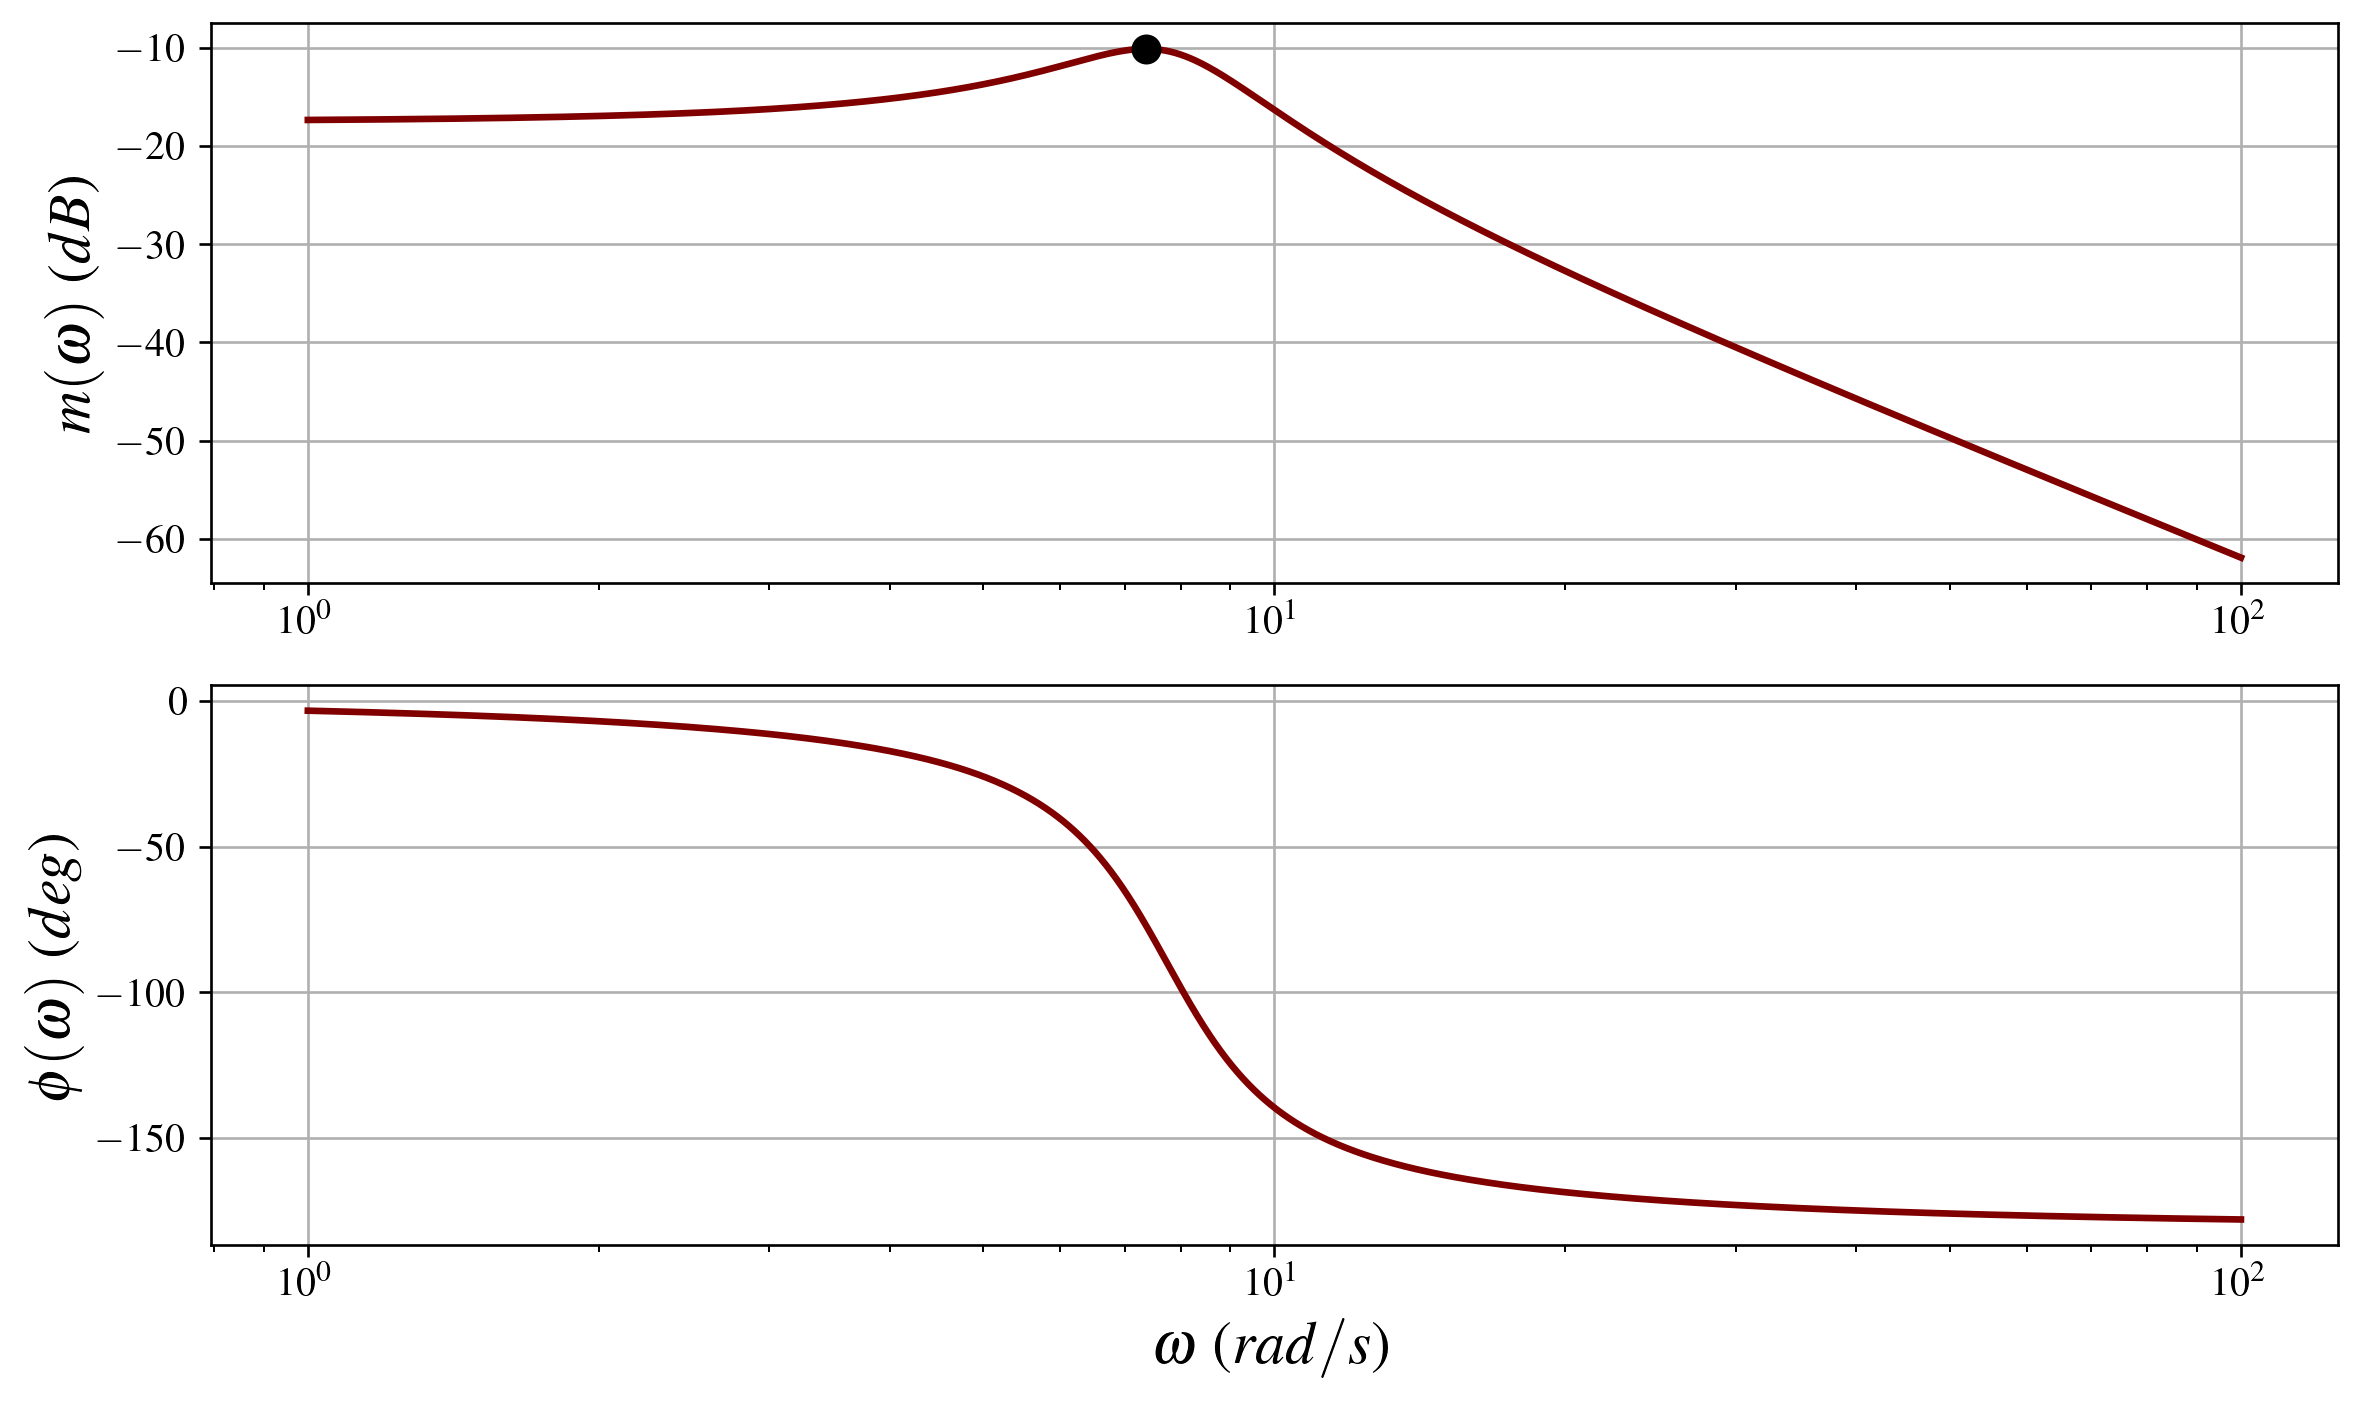

In [7]:
# Plotting
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.plot(omegas, 20*np.log10(mag), zorder=2)
ax1.scatter(wr, 20*np.log10(max(mag)), zorder=3, color='black')
ax1.set_ylabel(r'$m(\omega)$ ($dB$)')

ax2.plot(omegas, np.rad2deg(phase))
ax2.set_ylabel(r'$\phi(\omega)$  ($deg$)')
ax2.set_xlabel(r'$\omega$ ($rad/s$)')
plt.show()

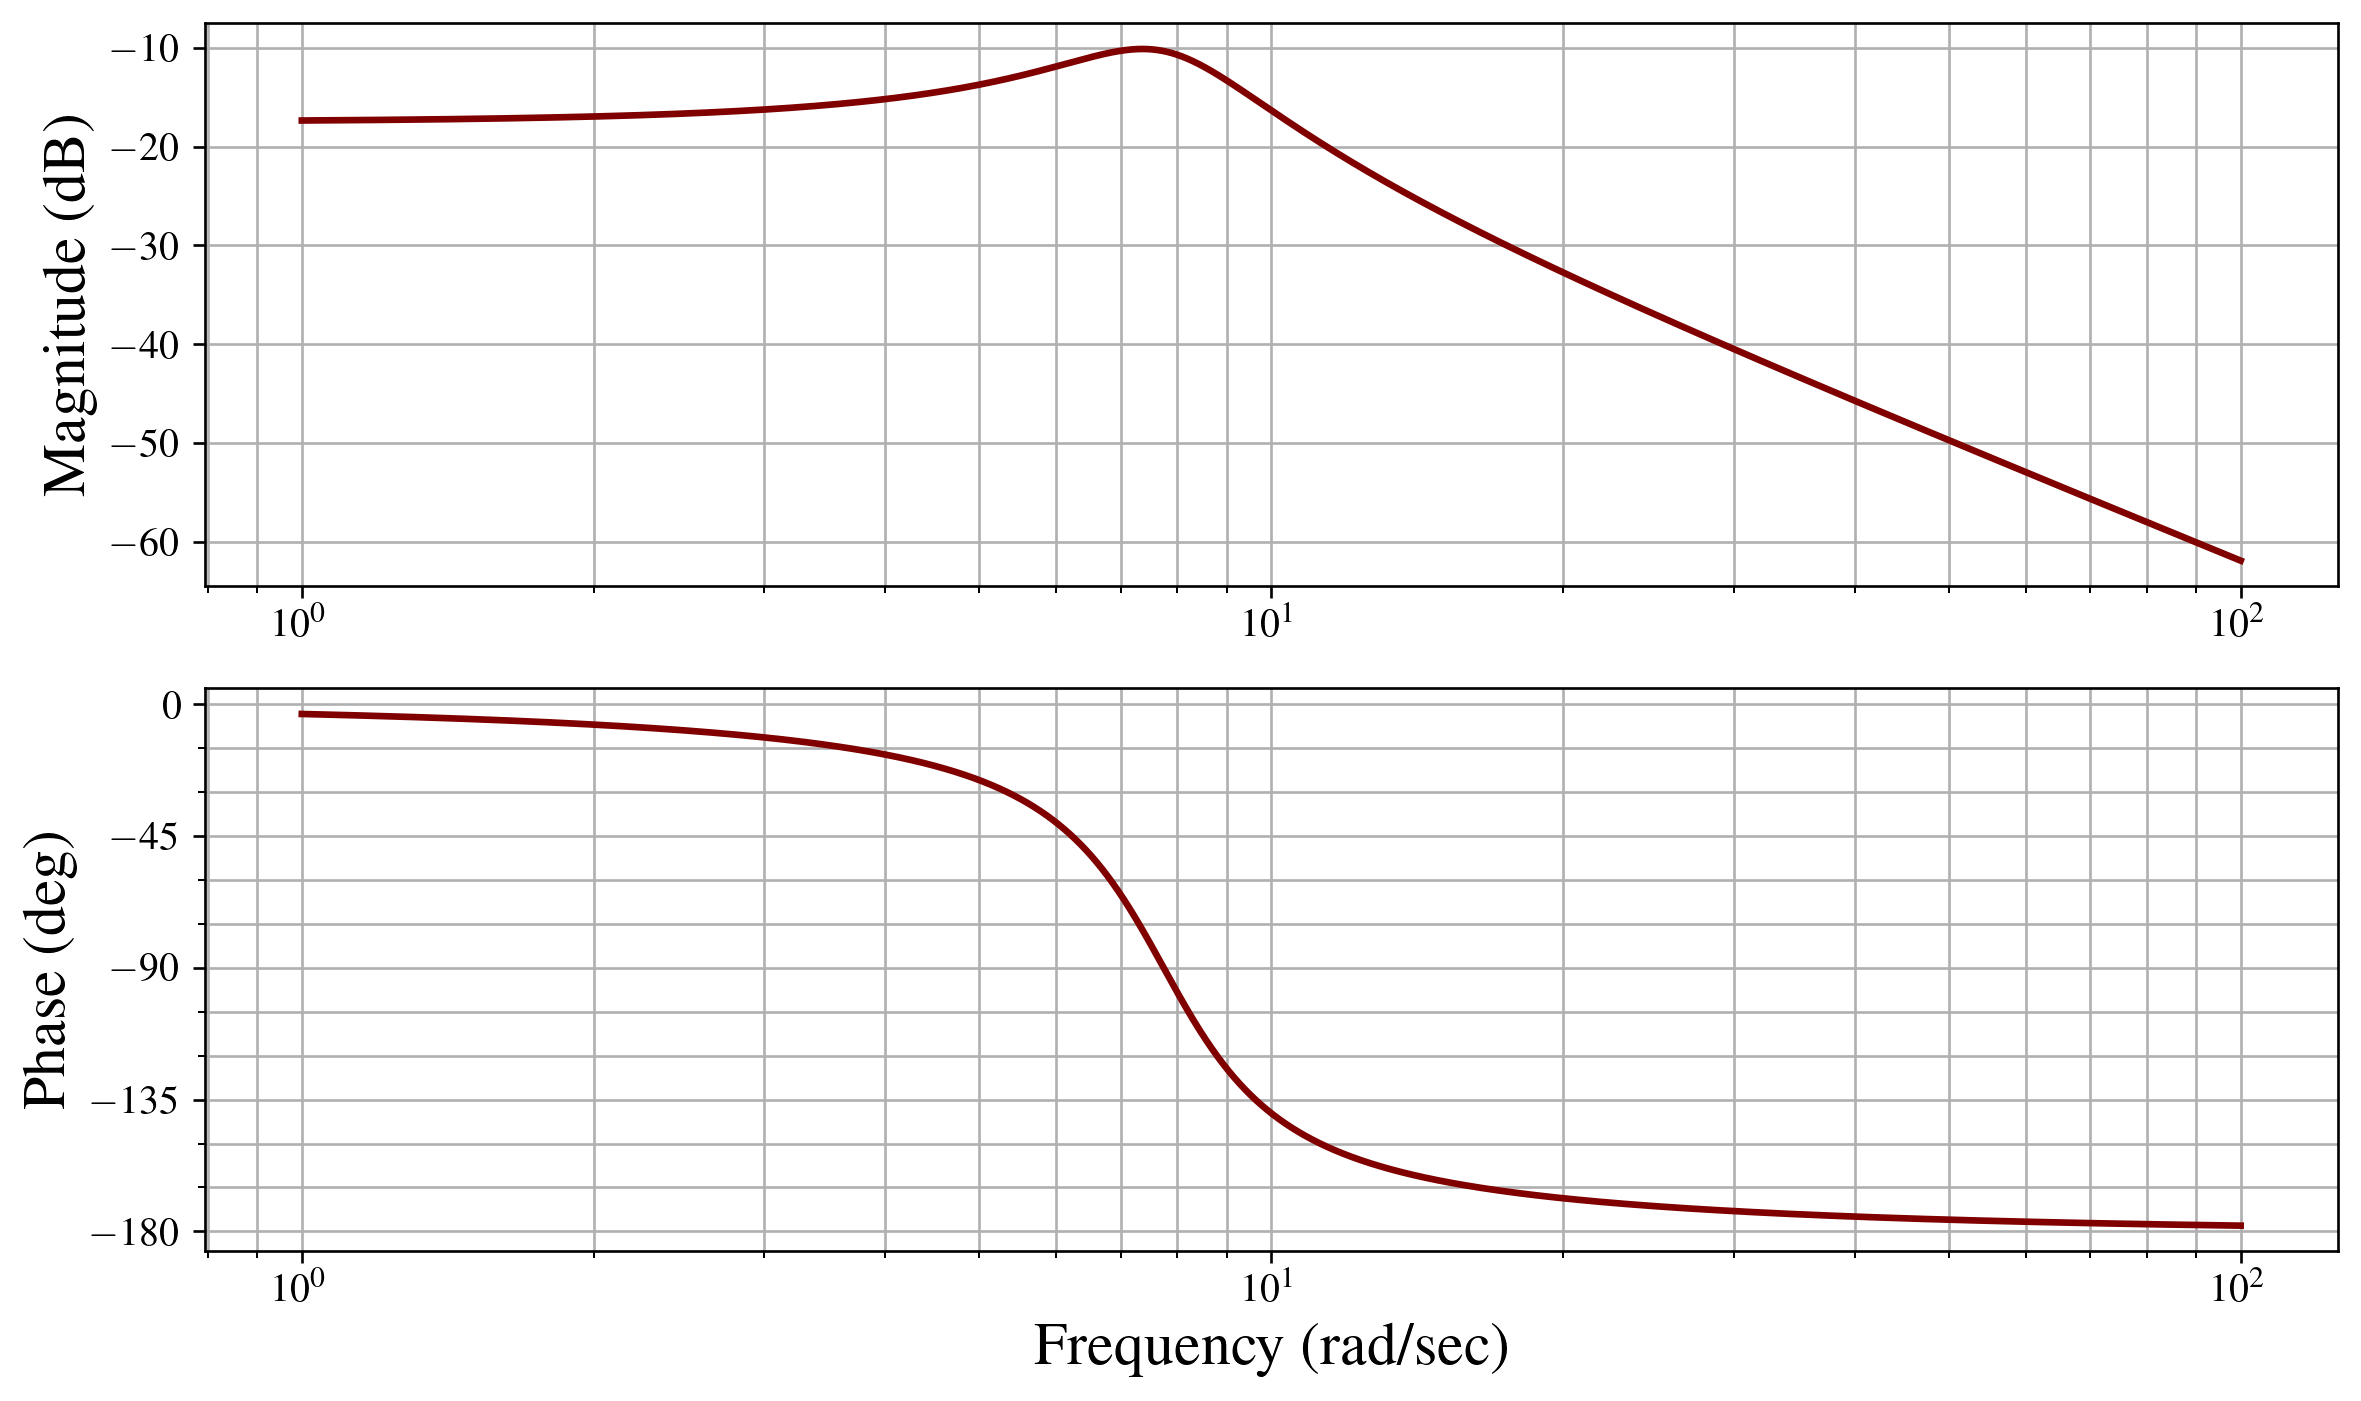

In [8]:
# Check with control package
mag, phase, omegas = ct.bode(T, omega=omegas, dB=True)

# Bandwidth
We need to find $\omega_1$ and $\omega_2$ such that 

$$M(\omega_1)\le\frac{M_{peak}}{\sqrt{2}}\ge M(\omega_2)$$

In [9]:
# If you have a fine resolution omegas, you could just use max(mag)
M_peak, _, _ = ct.frequency_response(T, wr)  # This function essentially does the same thing as bode() but it does not plot. It only returns the magnitude, phase, and omega.
M_peak = M_peak[0]  # M_peak is an array of one value ... we only want the float value

def find_band(om):
    # We need to return a value that is equal to zero
    # We first need to get the magnitude at the changing value of omega (om)
    mag_, phase_, omega_ = ct.frequency_response(T, om)
    # You could also use this line instead:
    # mag_ = np.abs(T_jw(om))
    
    # mag_ is an array of one value
    mag_ = mag_[0]
    return mag_ - M_peak/np.sqrt(2)
    
w1 = fsolve(find_band, np.array((wr - 1,)))[0]
w1  # rad/s

5.34095554215944

The `np.array((wr - 1,))` is the guess value. By subtracting 1 from the resonant frequency, we are ensuring that the solution will converge on the first bandwidth point. 

In [10]:
w2 = fsolve(find_band, np.array((wr + 1, )))[0]
w2  # rad/s

8.939473916102465

As seen above, this is a band-pass system with frequencies going from $5.34\,rad/s$ to $8.94\,rad/s$ affecting the system.

In [11]:
# The decibel magnitudes at w1 and w2 should be -3.01 dB from the peak
20*np.log10(M_peak) - 20*np.log10(np.abs(T_jw(w1)))

3.0102999566398143

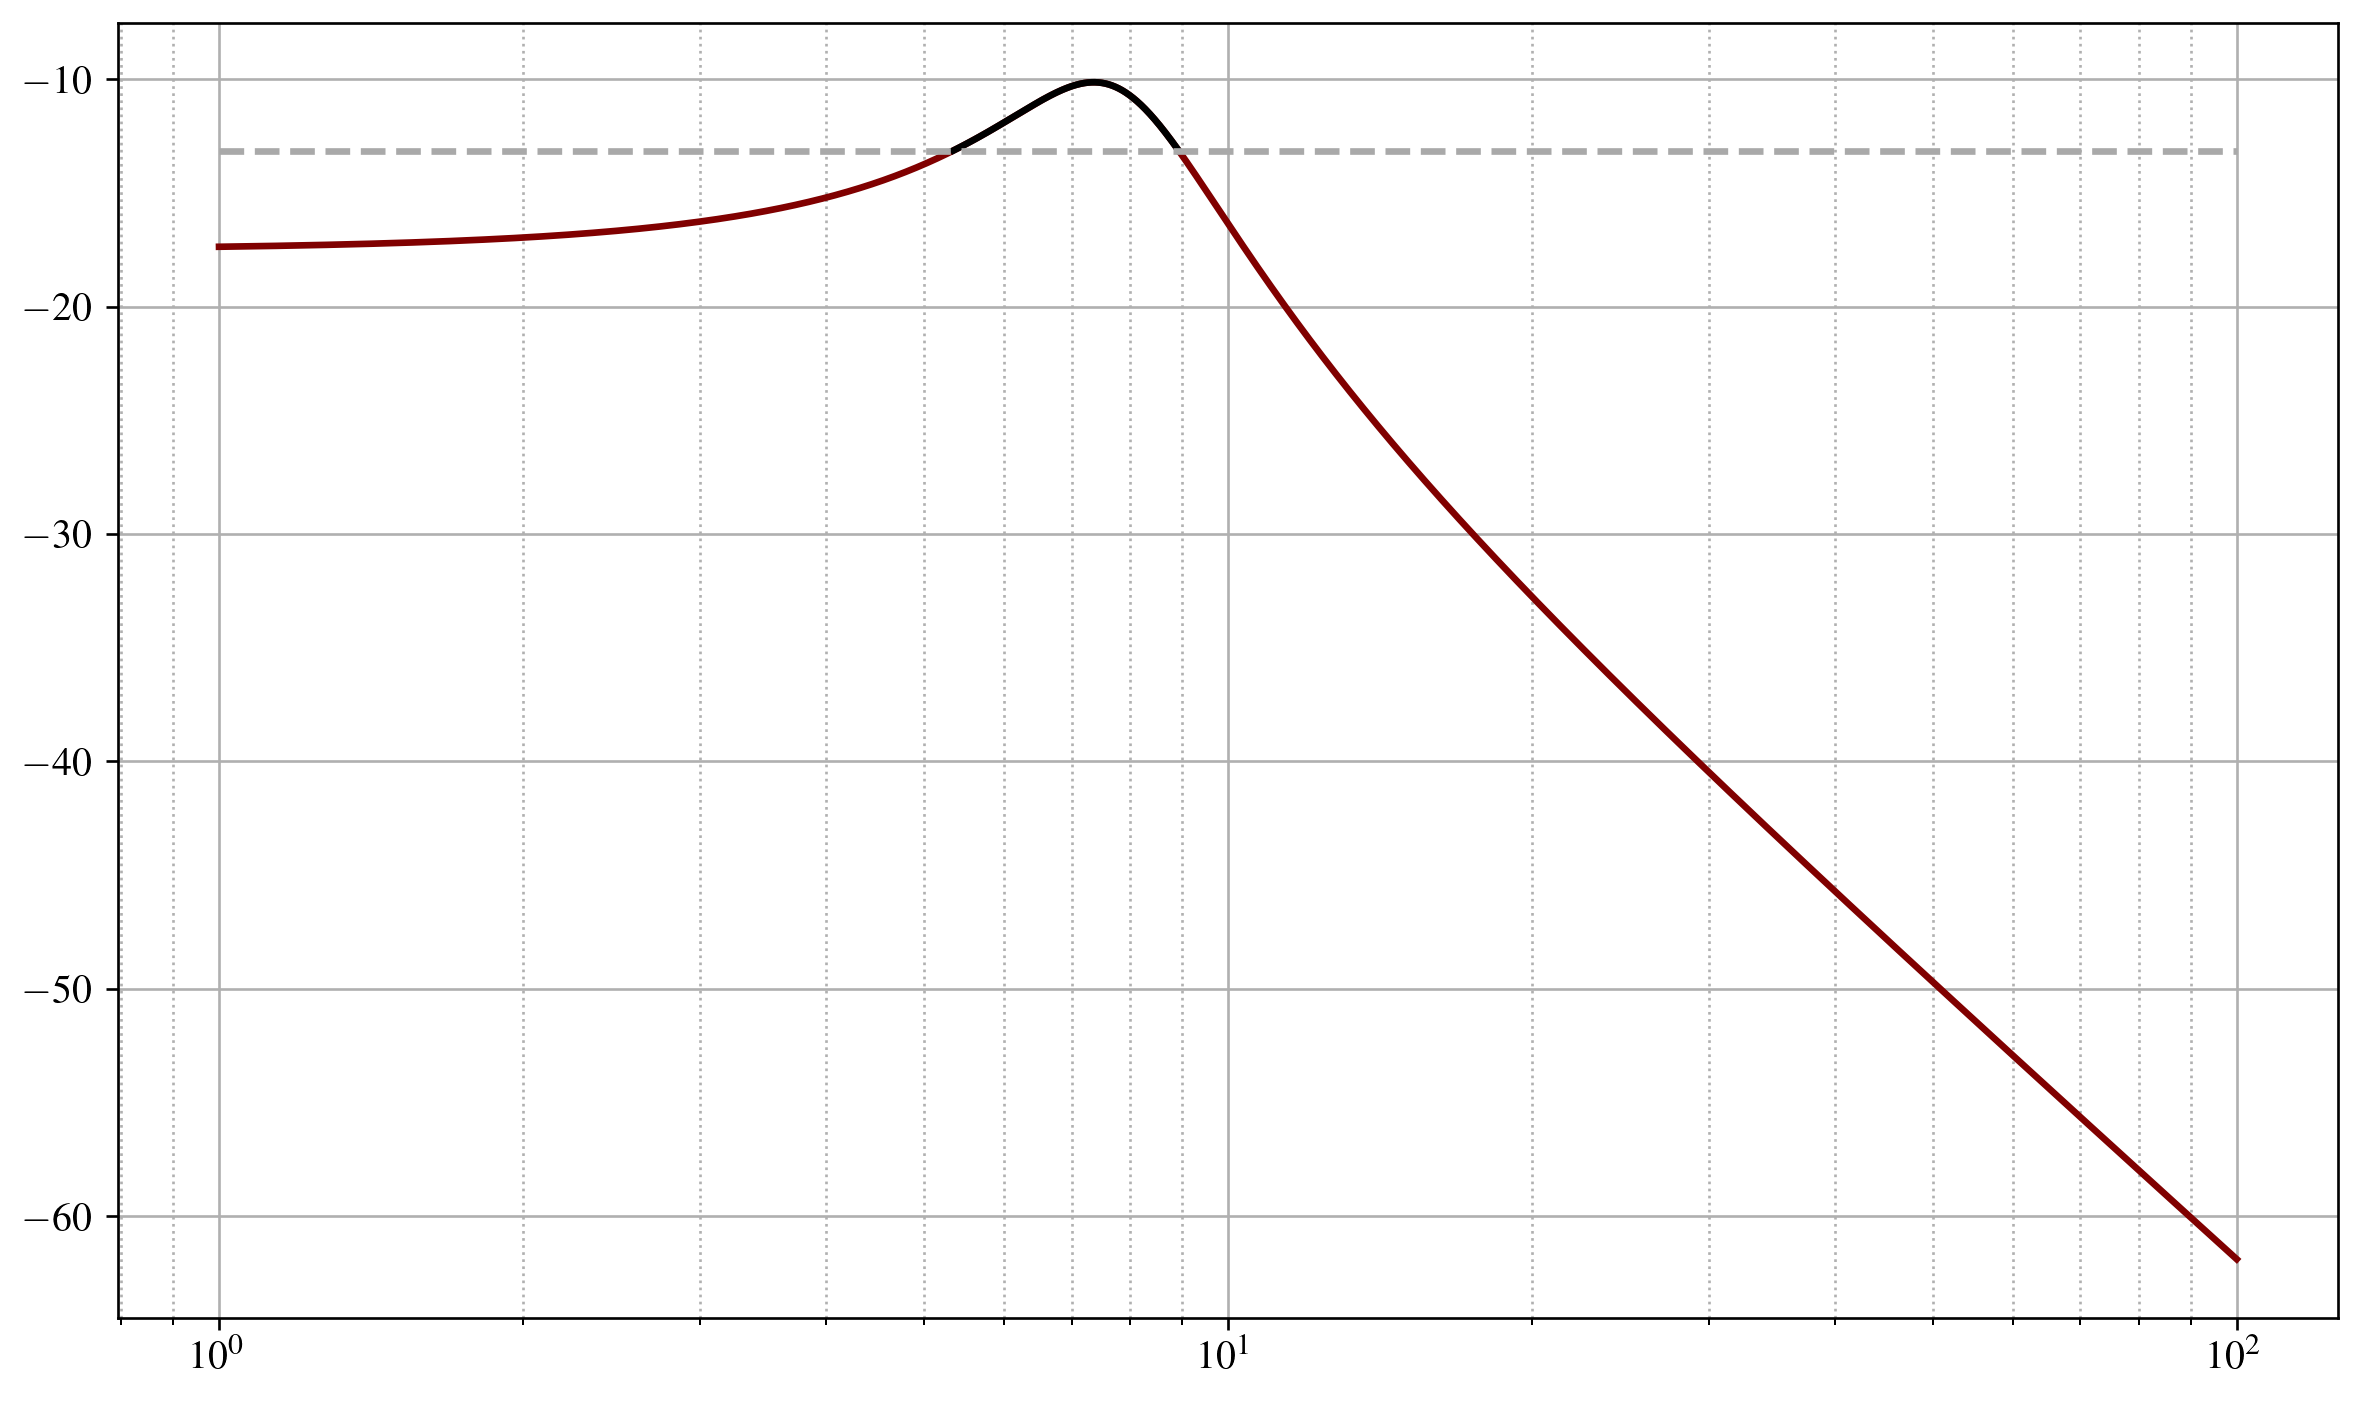

In [12]:
# Plotting the magnitude with the bandwidth
bandwidth = np.logical_and(omegas > w1, omegas <= w2)

fig, ax = plt.subplots()
ax.set_xscale('log')

ax.plot(omegas, 20*np.log10(mag))
ax.plot(omegas[bandwidth], 20*np.log10(mag[bandwidth]))
ax.plot([omegas[0], omegas[-1]], [20*np.log10(M_peak) + 20*np.log10(1/np.sqrt(2))]*2, ls='--')
ax.grid(which='minor', ls=':')  # Turning minor gridlines on
plt.show()